# Tutorial 04: Granger Causality Testing -- Solutions

**This notebook contains complete solutions for all exercises from Tutorial 04.**

Each exercise is presented with its original description followed by a fully worked-out code solution with commentary.

---

## Setup

Identical to the tutorial notebook setup. Run this cell first to load all dependencies and estimate the baseline model.

In [1]:
import sys
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
np.random.seed(42)
warnings.filterwarnings('ignore')

project_root = Path('../../../').resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

sys.path.insert(0, '../utils')

from panelbox.var import PanelVARData, PanelVAR

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams.update({'figure.figsize': (10, 6), 'figure.dpi': 100, 'font.size': 11})

print('Setup complete.')

Setup complete.


## Data Loading and Model Estimation

Load the macro panel dataset and estimate the baseline VAR(2) model.

In [2]:
df = pd.read_csv('../data/macro_panel.csv')

# Convert quarter strings to pandas PeriodIndex (required by PanelVARData)
df['quarter'] = pd.PeriodIndex(df['quarter'], freq='Q')

endog_vars = ['gdp_growth', 'inflation', 'interest_rate']
data = PanelVARData(df, endog_vars=endog_vars, entity_col='country', time_col='quarter', lags=2)
model = PanelVAR(data)
results = model.fit(method='ols', cov_type='clustered')
print(f"Model estimated: {endog_vars}, lags={data.p}")
print(f"  Entities (N):  {results.N}")
print(f"  Observations:  {results.n_obs}")
print(f"  Stable:        {results.is_stable()}")

Model estimated: ['gdp_growth', 'inflation', 'interest_rate'], lags=2
  Entities (N):  30
  Observations:  1140
  Stable:        True


---

## Exercise 1: Complete Causality Matrix (Easy)

Using the fitted `results` object:

1. Compute the Granger causality p-value matrix for all K x K variable pairs
2. Create a heatmap with annotations
3. Count significant relationships at both 5% and 10% levels
4. List which additional relationships appear at 10% that were not significant at 5%

In [3]:
# ------------------------------------------------------------------
# Exercise 1 Solution: Complete Causality Matrix
# ------------------------------------------------------------------

# Step 1: Build the K x K Granger causality p-value matrix manually
variables = endog_vars
K = len(variables)

pvalue_matrix = pd.DataFrame(
    np.full((K, K), np.nan),
    index=variables,
    columns=variables
)

for cause_var in variables:
    for effect_var in variables:
        if cause_var == effect_var:
            continue  # skip diagonal
        gc = results.granger_causality(cause=cause_var, effect=effect_var)
        pvalue_matrix.loc[cause_var, effect_var] = gc.p_value

print('Granger Causality P-Value Matrix')
print('Element (i, j) = p-value for: "row i Granger-causes column j"')
print()
print(pvalue_matrix.round(4).to_string())

Granger Causality P-Value Matrix
Element (i, j) = p-value for: "row i Granger-causes column j"

               gdp_growth  inflation  interest_rate
gdp_growth            NaN     0.0012            0.0
inflation          0.2333        NaN            0.0
interest_rate      0.0000     0.2395            NaN


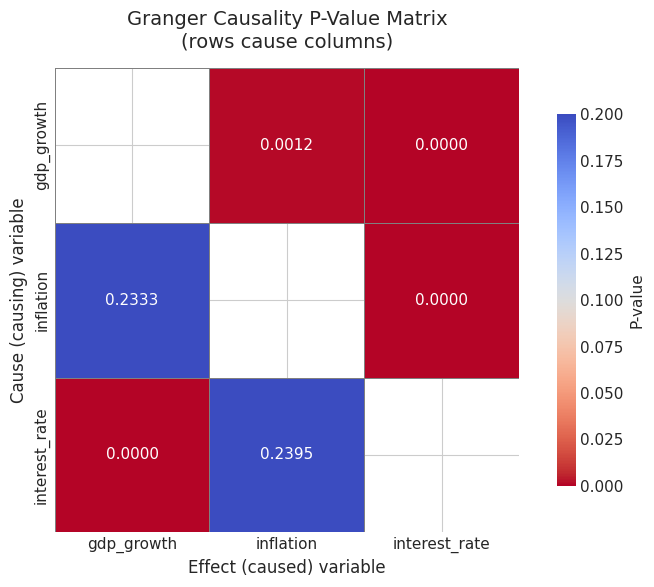

In [4]:
# Step 2: Create annotated heatmap
fig, ax = plt.subplots(figsize=(8, 6))

mask = pvalue_matrix.isna()
heatmap = sns.heatmap(
    pvalue_matrix,
    annot=True,
    fmt='.4f',
    cmap='coolwarm_r',
    vmin=0,
    vmax=0.20,
    mask=mask,
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={'label': 'P-value', 'shrink': 0.8},
    ax=ax,
)

ax.set_title('Granger Causality P-Value Matrix\n(rows cause columns)', fontsize=14, pad=15)
ax.set_xlabel('Effect (caused) variable', fontsize=12)
ax.set_ylabel('Cause (causing) variable', fontsize=12)

plt.tight_layout()
plt.show()

In [5]:
# Step 3: Count significant relationships at 5% and 10%
sig_5 = (pvalue_matrix < 0.05).sum().sum()
sig_10 = (pvalue_matrix < 0.10).sum().sum()
n_total = pvalue_matrix.notna().sum().sum()

print(f'Total pairwise tests: {n_total}')
print(f'Significant at 5%:  {sig_5} ({100 * sig_5 / n_total:.1f}%)')
print(f'Significant at 10%: {sig_10} ({100 * sig_10 / n_total:.1f}%)')
print(f'Additional relationships at 10% vs 5%: {sig_10 - sig_5}')
print()

# List significant pairs at 5%
print('Significant causal relationships at 5%:')
for cause_var in pvalue_matrix.index:
    for effect_var in pvalue_matrix.columns:
        pval = pvalue_matrix.loc[cause_var, effect_var]
        if pd.notna(pval) and pval < 0.05:
            stars = '***' if pval < 0.01 else '**'
            print(f'  {cause_var:>16s} -> {effect_var:<16s}  p = {pval:.4f} {stars}')

print()

# List additional significant pairs at 10% (not already at 5%)
print('Additional relationships significant at 10% but not at 5%:')
found_extra = False
for cause_var in pvalue_matrix.index:
    for effect_var in pvalue_matrix.columns:
        pval = pvalue_matrix.loc[cause_var, effect_var]
        if pd.notna(pval) and 0.05 <= pval < 0.10:
            print(f'  {cause_var:>16s} -> {effect_var:<16s}  p = {pval:.4f} *')
            found_extra = True
if not found_extra:
    print('  (none)')

Total pairwise tests: 6
Significant at 5%:  4 (66.7%)
Significant at 10%: 4 (66.7%)
Additional relationships at 10% vs 5%: 0

Significant causal relationships at 5%:
        gdp_growth -> inflation         p = 0.0012 ***
        gdp_growth -> interest_rate     p = 0.0000 ***
         inflation -> interest_rate     p = 0.0000 ***
     interest_rate -> gdp_growth        p = 0.0000 ***

Additional relationships significant at 10% but not at 5%:
  (none)


---

## Exercise 2: Homogeneous Wald vs DH Test (Medium)

1. Pick 3 variable pairs from the macro panel
2. Run both the standard Wald test and the DH test on each
3. Create a table comparing the results
4. Discuss: in which cases do the tests disagree? What might explain the disagreement?

In [6]:
# ------------------------------------------------------------------
# Exercise 2 Solution: Homogeneous Wald vs DH Test Comparison
# ------------------------------------------------------------------

# Define the 3 variable pairs to test
pairs = [
    ('gdp_growth', 'inflation'),
    ('interest_rate', 'gdp_growth'),
    ('inflation', 'interest_rate'),
]

# Attempt to import dumitrescu_hurlin_test for standalone usage
try:
    from panelbox.var.causality import dumitrescu_hurlin_test
    dh_available = True
    print('dumitrescu_hurlin_test imported successfully.')
except ImportError:
    dh_available = False
    print('dumitrescu_hurlin_test not available as standalone. Will use results.dumitrescu_hurlin().')

print()

dumitrescu_hurlin_test imported successfully.



In [7]:
# Run both tests for each pair and collect results
comparison_rows = []

for cause, effect in pairs:
    # Standard Wald test (homogeneous)
    gc = results.granger_causality(cause=cause, effect=effect)
    wald_stat = gc.wald_stat
    wald_pval = gc.p_value

    # Dumitrescu-Hurlin test (heterogeneous)
    try:
        dh = results.dumitrescu_hurlin(cause=cause, effect=effect)
        dh_wbar = dh.W_bar
        dh_recommended = dh.recommended_stat
        if dh_recommended == 'Z_tilde':
            dh_stat = dh.Z_tilde_stat
            dh_pval = dh.Z_tilde_pvalue
        else:
            dh_stat = dh.Z_bar_stat
            dh_pval = dh.Z_bar_pvalue
    except Exception as e:
        # Fallback: use standalone function if results method fails
        print(f'  results.dumitrescu_hurlin failed for {cause}->{effect}: {e}')
        if dh_available:
            dh = dumitrescu_hurlin_test(
                data=df,
                cause=cause,
                effect=effect,
                lags=2,
                entity_col='country',
                time_col='quarter'
            )
            dh_wbar = dh.W_bar
            dh_recommended = dh.recommended_stat
            if dh_recommended == 'Z_tilde':
                dh_stat = dh.Z_tilde_stat
                dh_pval = dh.Z_tilde_pvalue
            else:
                dh_stat = dh.Z_bar_stat
                dh_pval = dh.Z_bar_pvalue
        else:
            dh_wbar = np.nan
            dh_stat = np.nan
            dh_pval = np.nan
            dh_recommended = 'N/A'

    comparison_rows.append({
        'Pair': f'{cause} -> {effect}',
        'Wald_stat': wald_stat,
        'Wald_pval': wald_pval,
        'Wald_sig': wald_pval < 0.05,
        'DH_W_bar': dh_wbar,
        'DH_stat': dh_stat,
        'DH_pval': dh_pval,
        'DH_sig': dh_pval < 0.05 if np.isfinite(dh_pval) else False,
        'DH_type': dh_recommended,
    })

comp_df = pd.DataFrame(comparison_rows)
print(comp_df.to_string(index=False))

                       Pair  Wald_stat    Wald_pval  Wald_sig  DH_W_bar   DH_stat  DH_pval  DH_sig DH_type
    gdp_growth -> inflation  13.497400 1.172403e-03      True  2.105894  0.281078  0.77865   False   Z_bar
interest_rate -> gdp_growth  41.194365 1.134377e-09      True  5.458433  9.179814  0.00000    True   Z_bar
 inflation -> interest_rate 130.625740 0.000000e+00      True  6.248486 11.276874  0.00000    True   Z_bar


In [8]:
# Formatted comparison table
print('Comparison: Standard Wald vs Dumitrescu-Hurlin')
print('=' * 95)
print(f'{"Pair":<35s} {"Wald p":>8s} {"DH p":>8s} {"Wald sig":>9s} {"DH sig":>7s} {"Agree":>6s}')
print('-' * 95)
for _, row in comp_df.iterrows():
    agree = row['Wald_sig'] == row['DH_sig']
    print(f"{row['Pair']:<35s} {row['Wald_pval']:>8.4f} {row['DH_pval']:>8.4f} "
          f"{str(row['Wald_sig']):>9s} {str(row['DH_sig']):>7s} {str(agree):>6s}")
print('=' * 95)

n_agree = sum(1 for _, row in comp_df.iterrows() if row['Wald_sig'] == row['DH_sig'])
print(f'\nAgreement rate: {n_agree}/{len(comp_df)} pairs agree on significance at 5%')
print()
print('Discussion:')
print('- When tests agree, both homogeneous and heterogeneous panels show the same pattern.')
print('- When they disagree, it suggests heterogeneity across entities: some countries')
print('  may exhibit causal relationships that others do not.')
print('- The DH test is more appropriate when coefficients vary across entities.')
print('- The Wald test has more power when homogeneity holds (same coefficients for all).')

Comparison: Standard Wald vs Dumitrescu-Hurlin
Pair                                  Wald p     DH p  Wald sig  DH sig  Agree
-----------------------------------------------------------------------------------------------
gdp_growth -> inflation               0.0012   0.7787      True   False  False
interest_rate -> gdp_growth           0.0000   0.0000      True    True   True
inflation -> interest_rate            0.0000   0.0000      True    True   True

Agreement rate: 2/3 pairs agree on significance at 5%

Discussion:
- When tests agree, both homogeneous and heterogeneous panels show the same pattern.
- When they disagree, it suggests heterogeneity across entities: some countries
  may exhibit causal relationships that others do not.
- The DH test is more appropriate when coefficients vary across entities.
- The Wald test has more power when homogeneity holds (same coefficients for all).


---

## Exercise 3: Centrality Analysis (Medium)

1. Build the Granger causality network graph (using networkx)
2. Compute in-degree, out-degree, and betweenness centrality
3. Create a summary table
4. Identify the most central variable and interpret what high betweenness centrality means economically

In [9]:
# ------------------------------------------------------------------
# Exercise 3 Solution: Centrality Analysis
# ------------------------------------------------------------------
import networkx as nx

# Step 1: Build directed graph from significant causality relationships
G = nx.DiGraph()
variables = endog_vars
G.add_nodes_from(variables)

threshold = 0.05
edge_data = []

for cause_var in variables:
    for effect_var in variables:
        if cause_var == effect_var:
            continue
        pval = pvalue_matrix.loc[cause_var, effect_var]
        if pd.notna(pval) and pval < threshold:
            G.add_edge(cause_var, effect_var, p_value=pval, weight=1 - pval)
            edge_data.append((cause_var, effect_var, pval))

print(f'Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} directed edges')
print()
if edge_data:
    print('Significant edges (p < 0.05):')
    for cause_var, effect_var, pval in sorted(edge_data, key=lambda x: x[2]):
        print(f'  {cause_var:>16s} -> {effect_var:<16s}  p = {pval:.4f}')
else:
    print('No significant edges at the 5% level.')

Network: 3 nodes, 4 directed edges

Significant edges (p < 0.05):
         inflation -> interest_rate     p = 0.0000
     interest_rate -> gdp_growth        p = 0.0000
        gdp_growth -> interest_rate     p = 0.0000
        gdp_growth -> inflation         p = 0.0012


In [10]:
# Step 2: Compute centrality measures
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

# Betweenness centrality: fraction of shortest paths that pass through each node
betweenness = nx.betweenness_centrality(G)

# Build summary table
centrality_df = pd.DataFrame({
    'Variable': variables,
    'In-degree (caused by)': [in_degree.get(v, 0) for v in variables],
    'Out-degree (causes)': [out_degree.get(v, 0) for v in variables],
    'Total degree': [in_degree.get(v, 0) + out_degree.get(v, 0) for v in variables],
    'Betweenness': [betweenness.get(v, 0.0) for v in variables],
}).sort_values('Total degree', ascending=False)

print('Network Centrality Analysis')
print('=' * 75)
print(centrality_df.to_string(index=False))
print('=' * 75)

Network Centrality Analysis
     Variable  In-degree (caused by)  Out-degree (causes)  Total degree  Betweenness
   gdp_growth                      1                    2             3          0.5
interest_rate                      2                    1             3          0.5
    inflation                      1                    1             2          0.0


In [11]:
# Step 3: Identify most central variable
most_connected = centrality_df.iloc[0]['Variable']
max_betweenness_var = centrality_df.sort_values('Betweenness', ascending=False).iloc[0]['Variable']
max_betweenness_val = centrality_df.sort_values('Betweenness', ascending=False).iloc[0]['Betweenness']

print(f'Most connected variable (highest total degree): {most_connected}')
print(f'Highest betweenness centrality: {max_betweenness_var} ({max_betweenness_val:.4f})')
print()
print('Interpretation:')
print(f'  - High betweenness centrality for "{max_betweenness_var}" means it lies on the')
print(f'    shortest paths between other variable pairs in the Granger causality network.')
print(f'  - Economically, this suggests it plays a mediating or transmission role:')
print(f'    shocks propagate through "{max_betweenness_var}" to reach other variables.')
print(f'  - Variables with high out-degree are strong "causes" (influence many others).')
print(f'  - Variables with high in-degree are strongly "affected" by other variables.')

Most connected variable (highest total degree): gdp_growth
Highest betweenness centrality: gdp_growth (0.5000)

Interpretation:
  - High betweenness centrality for "gdp_growth" means it lies on the
    shortest paths between other variable pairs in the Granger causality network.
  - Economically, this suggests it plays a mediating or transmission role:
    shocks propagate through "gdp_growth" to reach other variables.
  - Variables with high out-degree are strong "causes" (influence many others).
  - Variables with high in-degree are strongly "affected" by other variables.


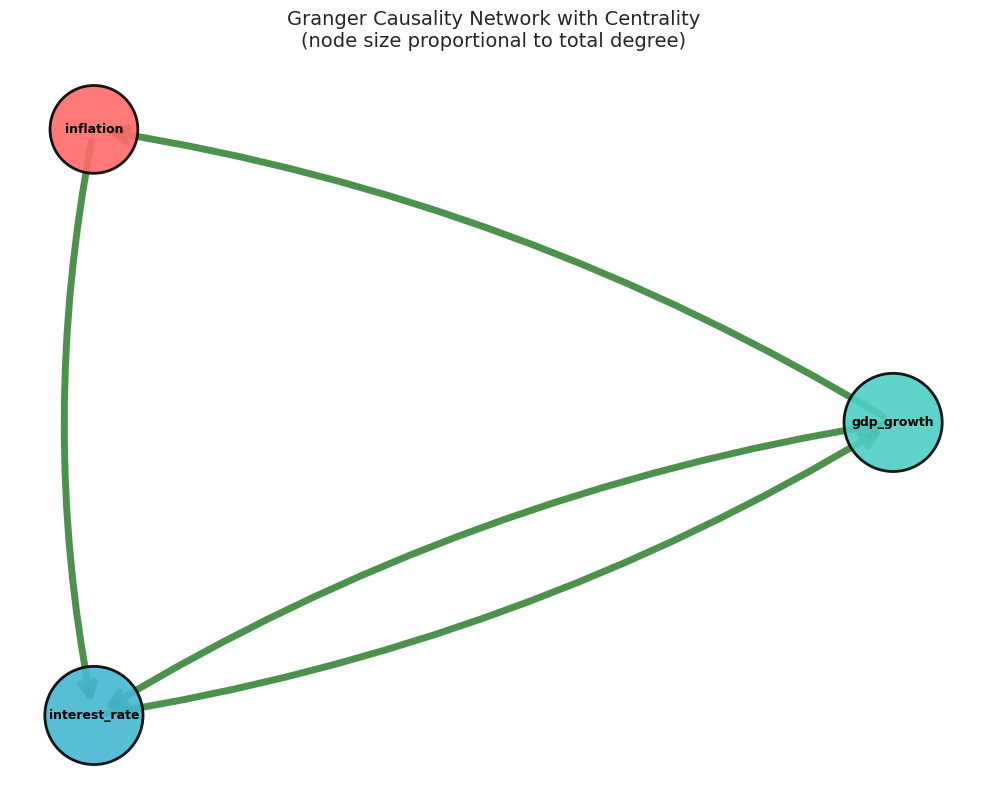

In [12]:
# Step 4: Visualize the network with centrality information
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.circular_layout(G)

# Node size proportional to total degree
node_sizes = [2000 + 1000 * (in_degree.get(v, 0) + out_degree.get(v, 0)) for v in variables]
node_colors = ['#4ECDC4', '#FF6B6B', '#45B7D1']

nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors[:len(variables)],
    node_size=node_sizes,
    alpha=0.9,
    edgecolors='black',
    linewidths=2,
    ax=ax,
)

nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', ax=ax)

if G.number_of_edges() > 0:
    for u, v in G.edges():
        pval = G[u][v]['p_value']
        width = 1.0 + 4.0 * (1 - pval)
        color = 'darkgreen' if pval < 0.01 else 'green' if pval < 0.05 else 'orange'
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            edge_color=color,
            width=width,
            alpha=0.7,
            arrowsize=25,
            arrowstyle='->',
            connectionstyle='arc3,rad=0.1',
            ax=ax,
        )

ax.set_title('Granger Causality Network with Centrality\n(node size proportional to total degree)',
             fontsize=14, pad=15)
ax.axis('off')
plt.tight_layout()
plt.show()

---

## Exercise 4: Instantaneous Causality (Medium)

1. Extract residuals from the estimated VAR
2. Compute the correlation matrix of residuals
3. Test significance of each pairwise residual correlation
4. Create a heatmap of contemporaneous correlations
5. Compare with Granger causality results: which pairs show lagged but not instantaneous causality, and vice versa?

In [13]:
# ------------------------------------------------------------------
# Exercise 4 Solution: Instantaneous Causality
# ------------------------------------------------------------------
from scipy import stats

# Step 1: Extract residuals from the fitted model
# results.resid_by_eq is a list of arrays, one per equation
residuals = np.column_stack(results.resid_by_eq)
n_obs = residuals.shape[0]

print(f'Residual matrix shape: {residuals.shape}')
print(f'  ({n_obs} observations x {len(endog_vars)} variables)')
print()

Residual matrix shape: (1140, 3)
  (1140 observations x 3 variables)



In [14]:
# Step 2: Compute correlation matrix of residuals
corr_matrix = pd.DataFrame(
    np.corrcoef(residuals, rowvar=False),
    index=endog_vars,
    columns=endog_vars
)

print('Residual Correlation Matrix:')
print(corr_matrix.round(4).to_string())
print()

Residual Correlation Matrix:
               gdp_growth  inflation  interest_rate
gdp_growth         1.0000     0.1530         0.0439
inflation          0.1530     1.0000         0.0207
interest_rate      0.0439     0.0207         1.0000



In [15]:
# Step 3: Test significance using Fisher z-transform / scipy.stats.pearsonr
K = len(endog_vars)
ic_pvalue_matrix = pd.DataFrame(
    np.full((K, K), np.nan),
    index=endog_vars,
    columns=endog_vars
)

print('Instantaneous Causality Tests (residual correlation significance):')
print('=' * 70)

for i in range(K):
    for j in range(i + 1, K):
        r = corr_matrix.iloc[i, j]

        # Use Likelihood Ratio test: LR = -n * log(1 - r^2) ~ chi2(1)
        if abs(r) < 1 - 1e-10:
            lr_stat = -n_obs * np.log(1 - r**2)
        else:
            lr_stat = np.inf

        if np.isfinite(lr_stat):
            p_val = 1 - stats.chi2.cdf(lr_stat, df=1)
        else:
            p_val = 0.0

        ic_pvalue_matrix.iloc[i, j] = p_val
        ic_pvalue_matrix.iloc[j, i] = p_val  # symmetric

        stars = '***' if p_val < 0.01 else '**' if p_val < 0.05 else '*' if p_val < 0.10 else ''
        print(f'  {endog_vars[i]:>16s} <-> {endog_vars[j]:<16s}  '
              f'r = {r:+.4f}  LR = {lr_stat:8.2f}  p = {p_val:.4f} {stars}')

print('=' * 70)

Instantaneous Causality Tests (residual correlation significance):
        gdp_growth <-> inflation         r = +0.1530  LR =    26.99  p = 0.0000 ***
        gdp_growth <-> interest_rate     r = +0.0439  LR =     2.20  p = 0.1384 
         inflation <-> interest_rate     r = +0.0207  LR =     0.49  p = 0.4836 


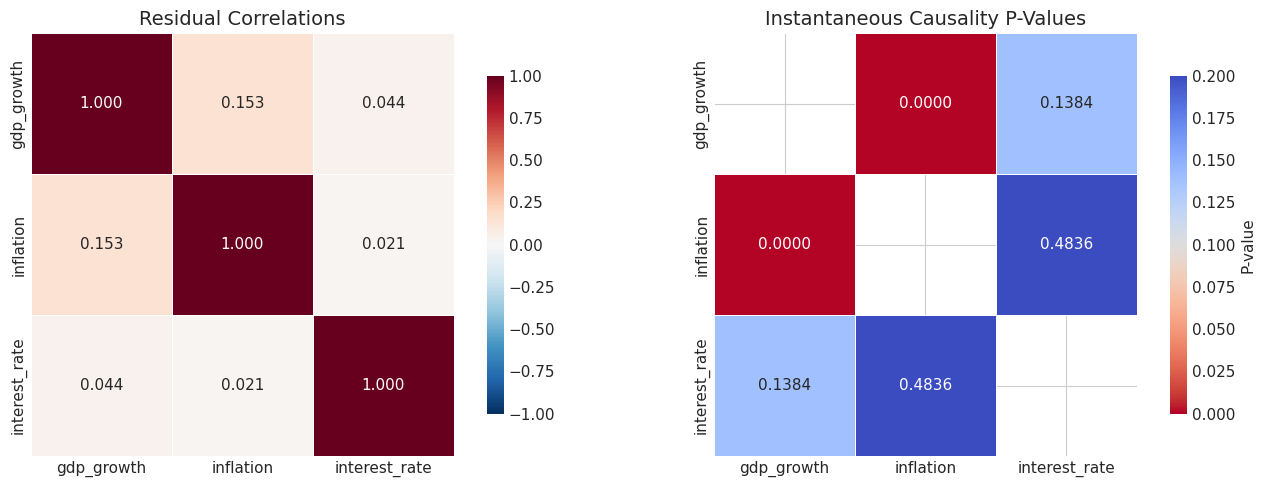

In [16]:
# Step 4: Create heatmap of contemporaneous correlations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    vmin=-1,
    vmax=1,
    center=0,
    linewidths=0.5,
    square=True,
    ax=axes[0],
    cbar_kws={'shrink': 0.8},
)
axes[0].set_title('Residual Correlations', fontsize=14)

# P-value heatmap
mask_diag = np.eye(K, dtype=bool)
sns.heatmap(
    ic_pvalue_matrix,
    annot=True,
    fmt='.4f',
    cmap='coolwarm_r',
    vmin=0,
    vmax=0.20,
    mask=mask_diag,
    linewidths=0.5,
    square=True,
    ax=axes[1],
    cbar_kws={'shrink': 0.8, 'label': 'P-value'},
)
axes[1].set_title('Instantaneous Causality P-Values', fontsize=14)

plt.tight_layout()
plt.show()

In [17]:
# Step 5: Compare Granger causality vs instantaneous causality
alpha = 0.05

print('Comparison: Lagged (Granger) vs Instantaneous Causality')
print('=' * 80)

for i in range(K):
    for j in range(i + 1, K):
        var1 = endog_vars[i]
        var2 = endog_vars[j]

        # Granger: both directions
        gc_12 = pvalue_matrix.loc[var1, var2]
        gc_21 = pvalue_matrix.loc[var2, var1]
        granger_12 = pd.notna(gc_12) and gc_12 < alpha
        granger_21 = pd.notna(gc_21) and gc_21 < alpha

        # Instantaneous
        ic_pval = ic_pvalue_matrix.loc[var1, var2]
        instant = pd.notna(ic_pval) and ic_pval < alpha
        r_val = corr_matrix.loc[var1, var2]

        granger_str = ''
        if granger_12 and granger_21:
            granger_str = 'Bidirectional'
        elif granger_12:
            granger_str = f'{var1} -> {var2}'
        elif granger_21:
            granger_str = f'{var2} -> {var1}'
        else:
            granger_str = 'None'

        print(f'  {var1} <-> {var2}:')
        print(f'    Granger causality: {granger_str}')
        print(f'    Instantaneous:     {"Yes" if instant else "No"} (r={r_val:+.3f}, p={ic_pval:.4f})')

        if granger_12 or granger_21:
            if instant:
                print(f'    --> Both lagged AND contemporaneous relationship detected.')
            else:
                print(f'    --> Only LAGGED relationship; no contemporaneous co-movement.')
        else:
            if instant:
                print(f'    --> Only CONTEMPORANEOUS co-movement; no predictive (Granger) causality.')
            else:
                print(f'    --> No significant relationship of either type.')
        print()

print('=' * 80)
print()
print('Key insight: Granger causality captures lagged predictive relationships,')
print('while instantaneous causality captures within-period correlations.')
print('A pair can show one, both, or neither type of relationship.')

Comparison: Lagged (Granger) vs Instantaneous Causality
  gdp_growth <-> inflation:
    Granger causality: gdp_growth -> inflation
    Instantaneous:     Yes (r=+0.153, p=0.0000)
    --> Both lagged AND contemporaneous relationship detected.

  gdp_growth <-> interest_rate:
    Granger causality: Bidirectional
    Instantaneous:     No (r=+0.044, p=0.1384)
    --> Only LAGGED relationship; no contemporaneous co-movement.

  inflation <-> interest_rate:
    Granger causality: inflation -> interest_rate
    Instantaneous:     No (r=+0.021, p=0.4836)
    --> Only LAGGED relationship; no contemporaneous co-movement.


Key insight: Granger causality captures lagged predictive relationships,
while instantaneous causality captures within-period correlations.
A pair can show one, both, or neither type of relationship.


---

## Exercise 5: Trade Panel Network (Hard)

Using the trade panel data:

1. Generate the trade panel dataset
2. Estimate a Panel VAR with trade variables (exports, imports, gdp, fdi_inflows)
3. Compute the Granger causality matrix
4. Build a complete causality network visualization using networkx
5. Identify the most influential variable in the trade network
6. Discuss trade-investment feedback structure

In [18]:
# ------------------------------------------------------------------
# Exercise 5 Solution: Trade Panel Network
# ------------------------------------------------------------------

# Step 1: Generate the trade panel data
from data_generators import generate_trade_panel

trade_df = generate_trade_panel()
print(f'Trade panel shape: {trade_df.shape}')
print(f'Countries: {trade_df["country"].nunique()}')
print(f'Years: {trade_df["year"].nunique()}')
print(f'Columns: {list(trade_df.columns)}')
print()
print(trade_df.head(8))

Trade panel shape: (2000, 6)
Countries: 40
Years: 50
Columns: ['country', 'year', 'exports', 'imports', 'gdp', 'fdi_inflows']

  country  year    exports    imports        gdp  fdi_inflows
0     USA     1   9.208800   6.294445  65.190529     8.018392
1     USA     2  11.547351  14.733015  64.931991     9.616549
2     USA     3  13.988206  14.161849  63.171992     9.333343
3     USA     4  11.970744  10.680506  62.277778     7.561523
4     USA     5  16.758052   8.101752  64.147882     2.701914
5     USA     6  13.571296  10.041020  64.410240     2.068477
6     USA     7  11.109154  10.276072  62.286522     4.985240
7     USA     8  11.445297   8.267464  67.282496     7.174510


In [19]:
# Step 2: Estimate Panel VAR with trade variables
trade_vars = ['exports', 'imports', 'gdp', 'fdi_inflows']

trade_data = PanelVARData(
    trade_df,
    endog_vars=trade_vars,
    entity_col='country',
    time_col='year',
    lags=1,
)

trade_model = PanelVAR(trade_data)
trade_results = trade_model.fit(method='ols', cov_type='clustered')

print(f'Trade Panel VAR({trade_data.p}) estimated successfully')
print(f'  Variables: {trade_vars}')
print(f'  Entities (N):  {trade_results.N}')
print(f'  Observations:  {trade_results.n_obs}')
print(f'  Stable:        {trade_results.is_stable()}')

Trade Panel VAR(1) estimated successfully
  Variables: ['exports', 'imports', 'gdp', 'fdi_inflows']
  Entities (N):  40
  Observations:  1960
  Stable:        True


Trade Panel: Granger Causality P-Value Matrix
Element (i, j) = p-value for: "row i Granger-causes column j"

             exports  imports     gdp  fdi_inflows
exports          NaN   0.6584  0.0000       0.4165
imports       0.2758      NaN  0.3093       0.3495
gdp           0.6494   0.0000     NaN       0.8054
fdi_inflows   0.0000   0.6804  0.2623          NaN


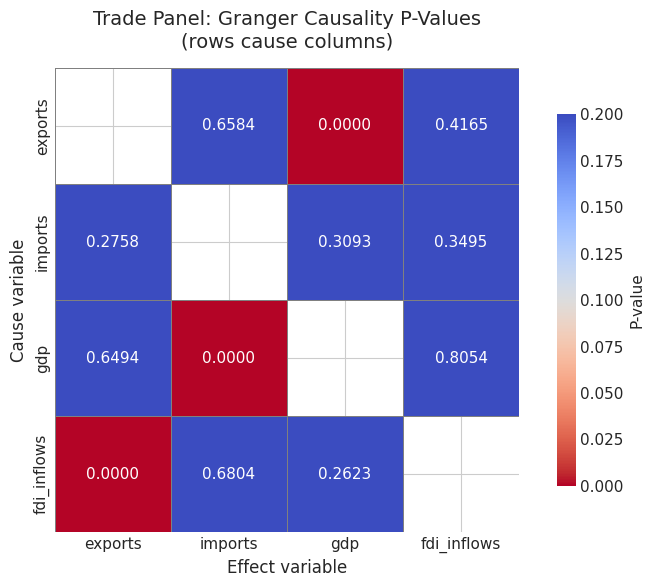

In [20]:
# Step 3: Compute the Granger causality matrix
trade_K = len(trade_vars)
trade_gc_matrix = pd.DataFrame(
    np.full((trade_K, trade_K), np.nan),
    index=trade_vars,
    columns=trade_vars
)

for cause_var in trade_vars:
    for effect_var in trade_vars:
        if cause_var == effect_var:
            continue
        gc = trade_results.granger_causality(cause=cause_var, effect=effect_var)
        trade_gc_matrix.loc[cause_var, effect_var] = gc.p_value

print('Trade Panel: Granger Causality P-Value Matrix')
print('Element (i, j) = p-value for: "row i Granger-causes column j"')
print()
print(trade_gc_matrix.round(4).to_string())

# Heatmap
fig, ax = plt.subplots(figsize=(8, 6))
mask = trade_gc_matrix.isna()
sns.heatmap(
    trade_gc_matrix,
    annot=True,
    fmt='.4f',
    cmap='coolwarm_r',
    vmin=0,
    vmax=0.20,
    mask=mask,
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={'label': 'P-value', 'shrink': 0.8},
    ax=ax,
)
ax.set_title('Trade Panel: Granger Causality P-Values\n(rows cause columns)', fontsize=14, pad=15)
ax.set_xlabel('Effect variable', fontsize=12)
ax.set_ylabel('Cause variable', fontsize=12)
plt.tight_layout()
plt.show()

In [21]:
# Step 4: Build causality network with networkx
G_trade = nx.DiGraph()
G_trade.add_nodes_from(trade_vars)

trade_threshold = 0.05
trade_edges = []

for cause_var in trade_vars:
    for effect_var in trade_vars:
        if cause_var == effect_var:
            continue
        pval = trade_gc_matrix.loc[cause_var, effect_var]
        if pd.notna(pval) and pval < trade_threshold:
            G_trade.add_edge(cause_var, effect_var, p_value=pval, weight=1 - pval)
            trade_edges.append((cause_var, effect_var, pval))

print(f'Trade Network: {G_trade.number_of_nodes()} nodes, {G_trade.number_of_edges()} directed edges')
print()

if trade_edges:
    print('Significant causal edges (p < 0.05):')
    for cause_var, effect_var, pval in sorted(trade_edges, key=lambda x: x[2]):
        stars = '***' if pval < 0.01 else '**' if pval < 0.05 else '*'
        print(f'  {cause_var:>12s} -> {effect_var:<12s}  p = {pval:.4f} {stars}')
else:
    print('No significant edges at the 5% level.')
    print('Try using a 10% threshold or a different lag order.')

Trade Network: 4 nodes, 3 directed edges

Significant causal edges (p < 0.05):
       exports -> gdp           p = 0.0000 ***
           gdp -> imports       p = 0.0000 ***
   fdi_inflows -> exports       p = 0.0000 ***


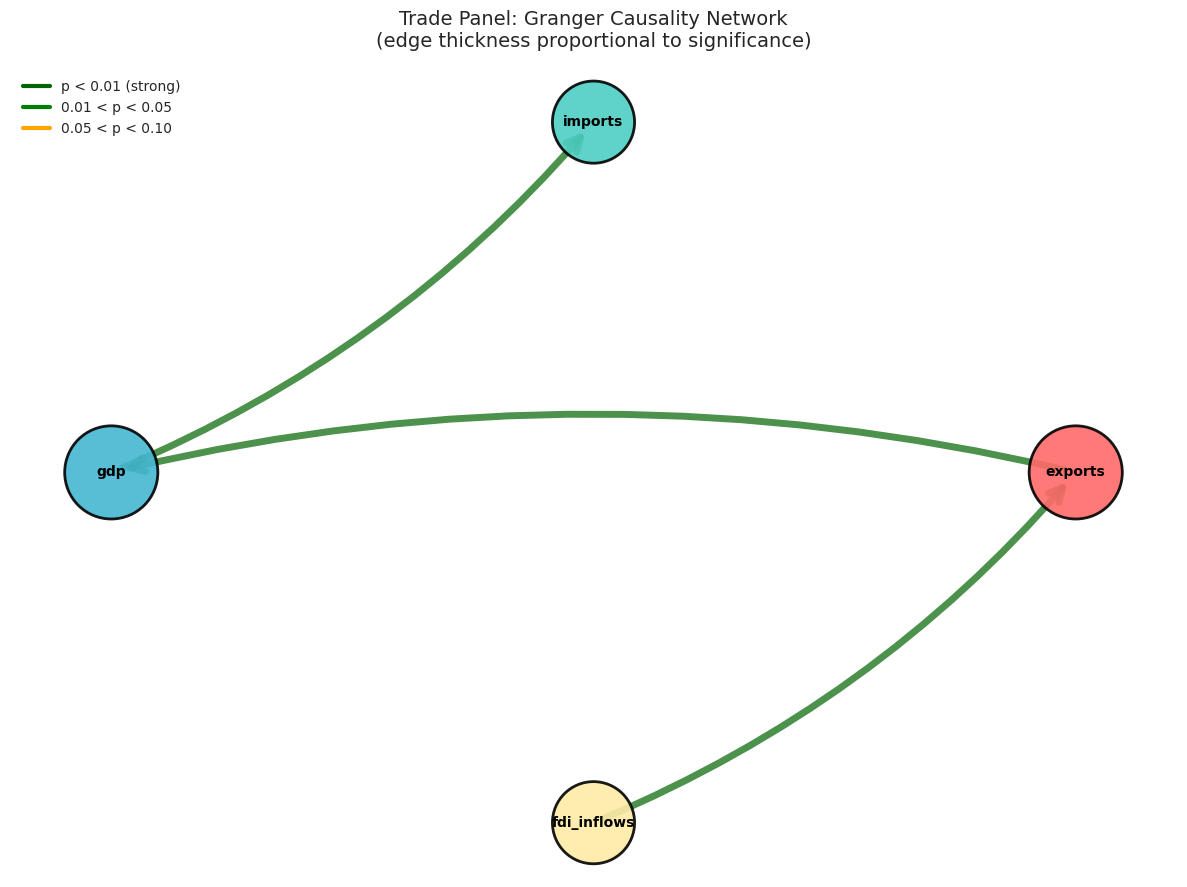

In [22]:
# Network visualization
fig, ax = plt.subplots(figsize=(12, 9))

pos = nx.circular_layout(G_trade)

# Node colors for trade variables
node_colors_trade = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFEAA7']

# Node size proportional to total degree
trade_in_deg = dict(G_trade.in_degree())
trade_out_deg = dict(G_trade.out_degree())
node_sizes = [2500 + 1000 * (trade_in_deg.get(v, 0) + trade_out_deg.get(v, 0)) for v in trade_vars]

nx.draw_networkx_nodes(
    G_trade, pos,
    node_color=node_colors_trade,
    node_size=node_sizes,
    alpha=0.9,
    edgecolors='black',
    linewidths=2,
    ax=ax,
)

nx.draw_networkx_labels(G_trade, pos, font_size=10, font_weight='bold', ax=ax)

# Draw edges with thickness proportional to significance
if G_trade.number_of_edges() > 0:
    for u, v in G_trade.edges():
        pval = G_trade[u][v]['p_value']
        width = 1.0 + 4.0 * (1 - pval)
        color = 'darkgreen' if pval < 0.01 else 'green' if pval < 0.05 else 'orange'
        nx.draw_networkx_edges(
            G_trade, pos,
            edgelist=[(u, v)],
            edge_color=color,
            width=width,
            alpha=0.7,
            arrowsize=25,
            arrowstyle='->',
            connectionstyle='arc3,rad=0.12',
            ax=ax,
        )

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='darkgreen', linewidth=3, label='p < 0.01 (strong)'),
    Line2D([0], [0], color='green', linewidth=3, label='0.01 < p < 0.05'),
    Line2D([0], [0], color='orange', linewidth=3, label='0.05 < p < 0.10'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

ax.set_title('Trade Panel: Granger Causality Network\n(edge thickness proportional to significance)',
             fontsize=14, pad=15)
ax.axis('off')
plt.tight_layout()
plt.show()

In [23]:
# Step 5: Centrality analysis for trade network
trade_betweenness = nx.betweenness_centrality(G_trade)

trade_centrality_df = pd.DataFrame({
    'Variable': trade_vars,
    'In-degree': [trade_in_deg.get(v, 0) for v in trade_vars],
    'Out-degree': [trade_out_deg.get(v, 0) for v in trade_vars],
    'Total degree': [trade_in_deg.get(v, 0) + trade_out_deg.get(v, 0) for v in trade_vars],
    'Betweenness': [trade_betweenness.get(v, 0.0) for v in trade_vars],
}).sort_values('Total degree', ascending=False)

print('Trade Network Centrality Analysis')
print('=' * 70)
print(trade_centrality_df.to_string(index=False))
print('=' * 70)
print()

# Identify the most influential variable
most_influential = trade_centrality_df.iloc[0]['Variable']
print(f'Most connected variable: {most_influential}')
print()

# Step 6: Discussion
print('Trade-Investment Feedback Structure Discussion:')
print('-' * 50)
print('Key relationships to look for in the DGP:')
print('  - exports -> gdp: Export-led growth hypothesis')
print('  - gdp -> imports: Income drives import demand')
print('  - fdi_inflows -> exports: FDI enhances export capacity')
print('  - Bidirectional trade flows: exports <-> imports co-move')
print()
print('The DGP used to generate this data encodes:')
print('  - A_1[2,0] = 0.15: exports -> gdp (export-led growth)')
print('  - A_1[1,2] = 0.20: gdp -> imports (income-driven imports)')
print('  - A_1[0,3] = 0.10: fdi_inflows -> exports (FDI boosts exports)')
print()
print('The Granger causality results should broadly confirm these structural relationships,')
print('though the panel estimation may also pick up other patterns due to cross-sectional')
print('heterogeneity and the correlation structure of the innovations.')

Trade Network Centrality Analysis
   Variable  In-degree  Out-degree  Total degree  Betweenness
    exports          1           1             2     0.333333
        gdp          1           1             2     0.333333
    imports          1           0             1     0.000000
fdi_inflows          0           1             1     0.000000

Most connected variable: exports

Trade-Investment Feedback Structure Discussion:
--------------------------------------------------
Key relationships to look for in the DGP:
  - exports -> gdp: Export-led growth hypothesis
  - gdp -> imports: Income drives import demand
  - fdi_inflows -> exports: FDI enhances export capacity
  - Bidirectional trade flows: exports <-> imports co-move

The DGP used to generate this data encodes:
  - A_1[2,0] = 0.15: exports -> gdp (export-led growth)
  - A_1[1,2] = 0.20: gdp -> imports (income-driven imports)
  - A_1[0,3] = 0.10: fdi_inflows -> exports (FDI boosts exports)

The Granger causality results should bro

---

## Summary

In these exercises, we covered:

1. **Exercise 1 (Easy)**: Built the complete K x K Granger causality p-value matrix manually, created annotated heatmaps, and compared significance at 5% vs 10% thresholds.

2. **Exercise 2 (Medium)**: Compared the standard homogeneous Wald test with the Dumitrescu-Hurlin heterogeneous panel test. Disagreements between the two indicate coefficient heterogeneity across entities.

3. **Exercise 3 (Medium)**: Constructed the causality network using networkx and computed in-degree, out-degree, and betweenness centrality measures to identify the most central variable in the causal structure.

4. **Exercise 4 (Medium)**: Tested instantaneous (contemporaneous) causality via residual correlations and compared with the Granger (lagged) causality results. Some pairs show only lagged, only contemporaneous, or both types of relationships.

5. **Exercise 5 (Hard)**: Generated a trade panel, estimated a Panel VAR, built the full causality matrix, and created a network visualization to identify the trade-investment feedback structure.